Fitting 5 folds for each of 27 candidates, totalling 135 fits
Stacking - Accuracy : 0.955984555984556
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5195
           1       0.96      0.95      0.96      5165

    accuracy                           0.96     10360
   macro avg       0.96      0.96      0.96     10360
weighted avg       0.96      0.96      0.96     10360

Voting - Accuracy : 0.9524131274131274
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5195
           1       0.98      0.93      0.95      5165

    accuracy                           0.95     10360
   macro avg       0.95      0.95      0.95     10360
weighted avg       0.95      0.95      0.95     10360


Validation croisée pour le modèle Stacking :
Accuracy moyenne (Stacking) : 0.9527
Écart-type des scores (Stacking) : 0.0016

Importance des caractéristiques (Random Forest) :


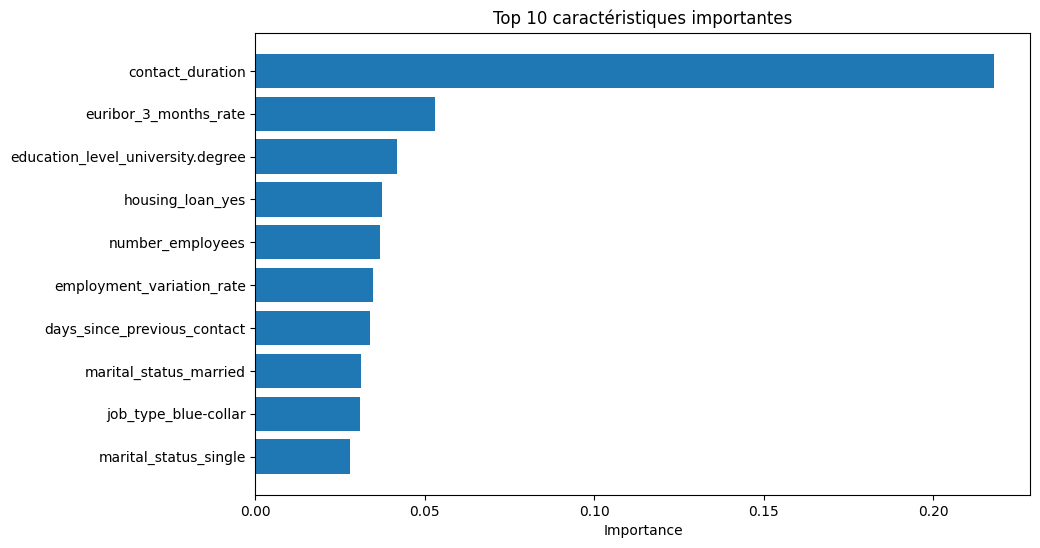

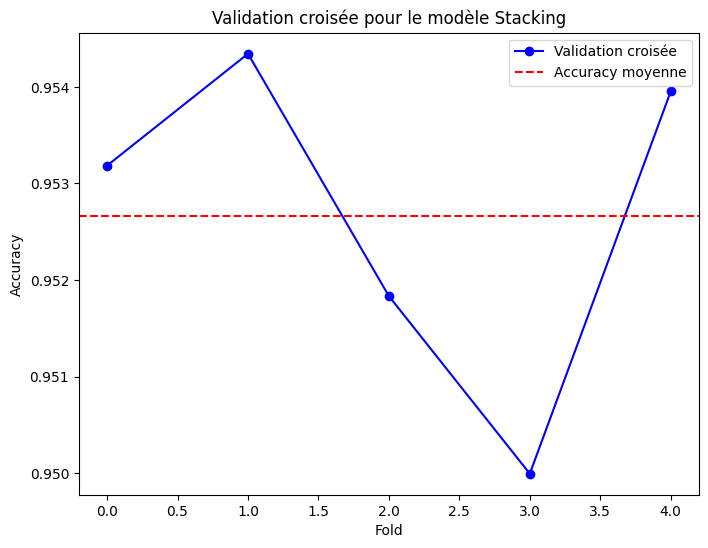

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import joblib
import json

# Charger le dataset nettoyé avec une gestion d'erreur
try:
    data = pd.read_csv('C:/Users/EBM/Desktop/projet_ML/dataset_cleaned.csv')
except FileNotFoundError:
    print("Erreur : Le fichier CSV n'a pas été trouvé.")
    exit()

# Vérifier la présence de la colonne cible 'y'
if 'y' not in data.columns:
    print("Erreur : La colonne cible 'y' est manquante.")
    exit()

# Séparation des caractéristiques (X) et de la variable cible (y)
X = data.drop('y', axis=1)  
y = data['y']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir les modèles de base
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Définir le modèle de niveau supérieur (métamodèle)
meta_learner = LogisticRegression()

# Créer le modèle Stacking
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Recherche d'hyperparamètres pour améliorer Stacking avec GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'gb__n_estimators': [50, 100, 150],
    'final_estimator__C': [0.1, 1, 10]
}
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_stacking_model = grid_search.best_estimator_

# Sauvegarder le modèle Stacking
joblib.dump(best_stacking_model, 'best_stacking_model.joblib')

# Prédictions et évaluation pour Stacking
y_pred_stacking = best_stacking_model.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
classification_report_stacking = classification_report(y_test, y_pred_stacking)

# Sauvegarder les résultats dans un fichier JSON
results = {
    'stacking': {
        'accuracy': accuracy_stacking,
        'classification_report': classification_report_stacking
    }
}

# Sauvegarder les résultats dans un fichier JSON
with open('stacking_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"Stacking - Accuracy : {accuracy_stacking}")
print(classification_report_stacking)

# Définir les modèles pour Voting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Créer le modèle Voting (Hard Voting ou Soft Voting)
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='hard')

# Entraîner le modèle Voting
voting_model.fit(X_train, y_train)

# Sauvegarder le modèle Voting
joblib.dump(voting_model, 'voting_model.joblib')

# Prédictions et évaluation pour Voting
y_pred_voting = voting_model.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
classification_report_voting = classification_report(y_test, y_pred_voting)

# Sauvegarder les résultats dans le fichier JSON
results['voting'] = {
    'accuracy': accuracy_voting,
    'classification_report': classification_report_voting
}

# Sauvegarder les résultats dans un fichier JSON
with open('stacking_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"Voting - Accuracy : {accuracy_voting}")
print(classification_report_voting)

# Ajout de la validation croisée pour le modèle Stacking
print("\nValidation croisée pour le modèle Stacking :")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_stacking_model, X, y, cv=skf, scoring='accuracy')
cv_accuracy_mean = cv_scores.mean()
cv_accuracy_std = cv_scores.std()

print(f"Accuracy moyenne (Stacking) : {cv_accuracy_mean:.4f}")
print(f"Écart-type des scores (Stacking) : {cv_accuracy_std:.4f}")

# Ajouter les résultats de la validation croisée dans le fichier JSON
results['stacking_cv'] = {
    'accuracy_mean': cv_accuracy_mean,
    'accuracy_std': cv_accuracy_std
}

# Sauvegarder les résultats dans un fichier JSON
with open('stacking_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Visualisation des caractéristiques importantes pour Random Forest
print("\nImportance des caractéristiques (Random Forest) :")
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualisation
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 caractéristiques importantes")
plt.xlabel("Importance")
plt.show()

# Visualisation de la performance de la validation croisée pour Stacking
plt.figure(figsize=(8, 6))
plt.plot(cv_scores, marker='o', label='Validation croisée', color='b')
plt.axhline(y=cv_accuracy_mean, color='r', linestyle='--', label='Accuracy moyenne')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Validation croisée pour le modèle Stacking')
plt.legend()
plt.show()
